In [1]:
import tensorflow as tf

2024-11-15 21:48:52.573344: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 21:48:52.583415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731694732.594842   88426 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731694732.597901   88426 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 21:48:52.612854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# downloading dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("talhasar/genki4k")

print("Path to dataset files:", path)

/home/milad/miniconda3/envs/ai-lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/milad/.cache/kagglehub/datasets/talhasar/genki4k/versions/1


# cropping face

In [3]:
from face_crop import FaceAligner
import os
import cv2

In [4]:
face_aligner = FaceAligner()

dataset_path= os.path.join(path, list(os.listdir(path))[0])
cropped_path = dataset_path + '-cropped'

for dir in os.listdir(dataset_path):
    for root, _, files in os.walk(os.path.join(dataset_path, dir)):
        os.makedirs(os.path.join(cropped_path, dir), exist_ok=True)
        for file in files:
            face_image = face_aligner.align_face(os.path.join(root, file))
            if face_image is not None:
                cv2.imwrite(os.path.join(cropped_path, dir, file), face_image)

MESA: error: ZINK: failed to choose pdev
libEGL warning: egl: failed to create dri2 screen
I0000 00:00:1731694735.590928   88426 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731694735.604477   88548 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (Intel(R) Iris(R) Xe Graphics)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1731694735.608534   88531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.


# split and loading data

In [5]:
# Define the path to your dataset
dataset_path = cropped_path

# Parameters for splitting
validation_split = 0.2  # 20% for validation
batch_size = 128
IMG_SIZE = (224, 224)  # Resize images to 224x224

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="training",
    seed=12,  # Ensure reproducibility
    image_size=IMG_SIZE,
    batch_size=batch_size
)

# Load validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="validation",
    seed=12,  # Ensure reproducibility
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 3896 files belonging to 2 classes.
Using 3117 files for training.


I0000 00:00:1731694753.555643   88426 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 3896 files belonging to 2 classes.
Using 779 files for validation.


# Show the first nine images and labels from the training set

In [6]:
from matplotlib import pyplot as plt

2024-11-15 21:49:14.751043: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


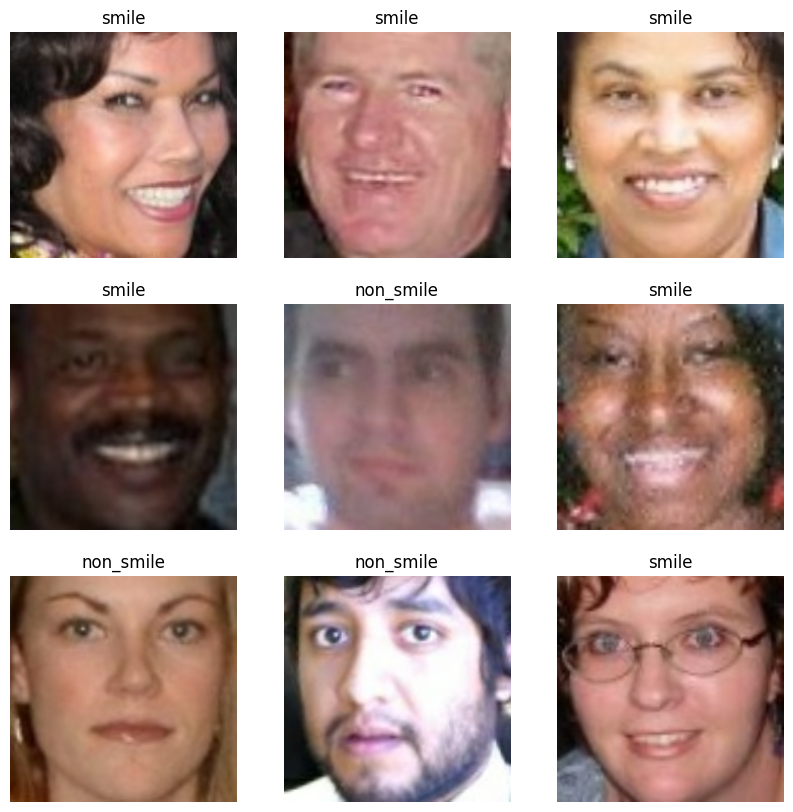

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augmentation and preview

In [9]:
from tensorflow.keras import layers

# Define augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip horizontally
    # layers.RandomRotation(0.2),  # Rotate by 20%
    layers.RandomBrightness(factor=0.3),  # Adjust brightness randomly
]
)

2024-11-15 21:49:16.306902: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


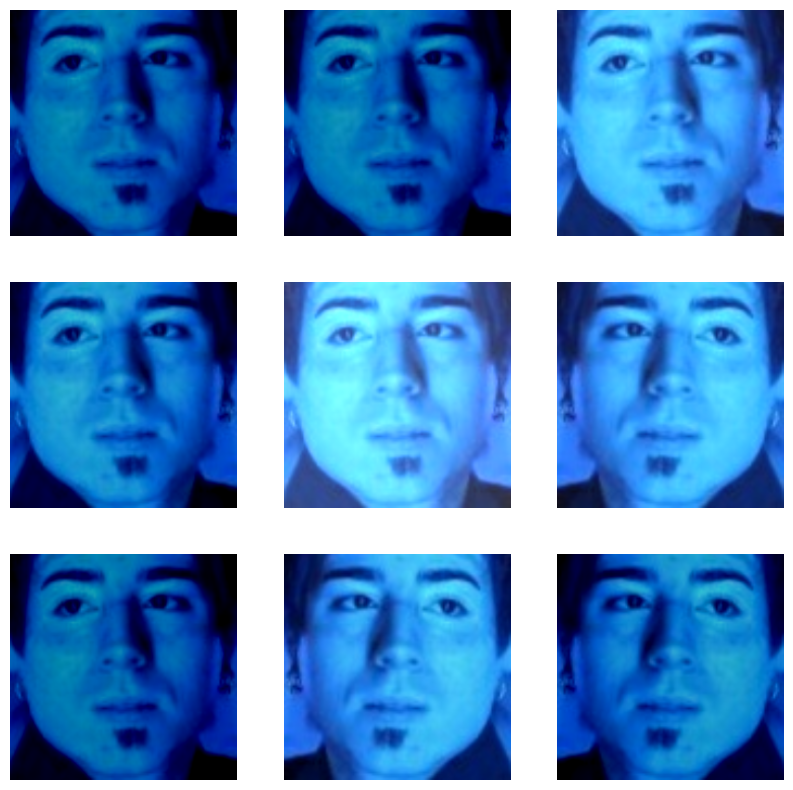

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Load the model

In [11]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [ ]:
from tensorflow.keras import Model

# ! wget https://www.kaggle.com/api/v1/models/mahdihassani83/facedetectionbyresnet50v2/tensorFlow2/emotion_detection_model/1/download
# ! gzip -d facedetectionbyresnet50v2-tensorflow2-emotion_detection_model-v1.tar.gz

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.models.load_model('ResNet50V2_Model.h5')
base_model.summary()

/home/milad/miniconda3/envs/ai-lab/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,297 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

 Optimizer params: 2 (12.00 B)

# Preparing model for fine-tuning

In [13]:
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization

input_shape = base_model.input_shape[1:]
new_input = Input(shape=input_shape)
x = new_input
x = data_augmentation(x)
x = preprocess_input(x)
for layer in base_model.layers[:-4]: 
    x = layer(x)
x = Dense(128, activation='relu', name='dense_1')(x)
x = BatchNormalization(name='batch_norm_1')(x)
x = Dropout(0.6, name='dropout_1')(x)
x = Dense(64, activation='relu', name='dense_2')(x)
x = BatchNormalization(name='batch_norm_2')(x)
x = Dropout(0.6, name='dropout_2')(x)
output = Dense(1, activation='sigmoid', name='dense_3')(x) 

final_model = Model(inputs=new_input, outputs=output)
final_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,427,265 (138.96 MB)

 Trainable params: 29,210,241 (111.43 MB)

 Non-trainable params: 7,217,024 (27.53 MB)

# Compile the model

In [14]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# Train the model

In [15]:
initial_epochs = 6

history = final_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/6


I0000 00:00:1731694766.467603   88686 service.cc:148] XLA service 0x776d38003400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731694766.467644   88686 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-11-15 21:49:26.675767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731694767.744334   88686 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731694786.578344   88686 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8359 - loss: 0.3976

2024-11-15 21:49:55.542360: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng53{k2=8,k13=1,k14=3,k18=0,k23=0} for conv (f32[45,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[45,256,56,56]{3,2,1,0}, f32[64,256,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-15 21:49:55.542478: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.138797308s
Trying algorithm eng53{k2=8,k13=1,k14=3,k18=0,k23=0} for conv (f32[45,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[45,256,56,56]{3,2,1,0}, f32[64,256,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backe

25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8409 - loss: 0.3875 - val_accuracy: 0.7818 - val_loss: 63.5686
Epoch 2/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9432 - loss: 0.1594 - val_accuracy: 0.8460 - val_loss: 6.0037
Epoch 3/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.9520 - loss: 0.1643 - val_accuracy: 0.9384 - val_loss: 0.6872
Epoch 4/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9718 - loss: 0.0811 - val_accuracy: 0.9448 - val_loss: 0.3080
Epoch 5/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.9791 - loss: 0.0711 - val_accuracy: 0.9487 - val_loss: 0.2260
Epoch 6/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.9685 - loss: 0.0905 - val_accuracy: 0.9525 - val_loss: 0.2277


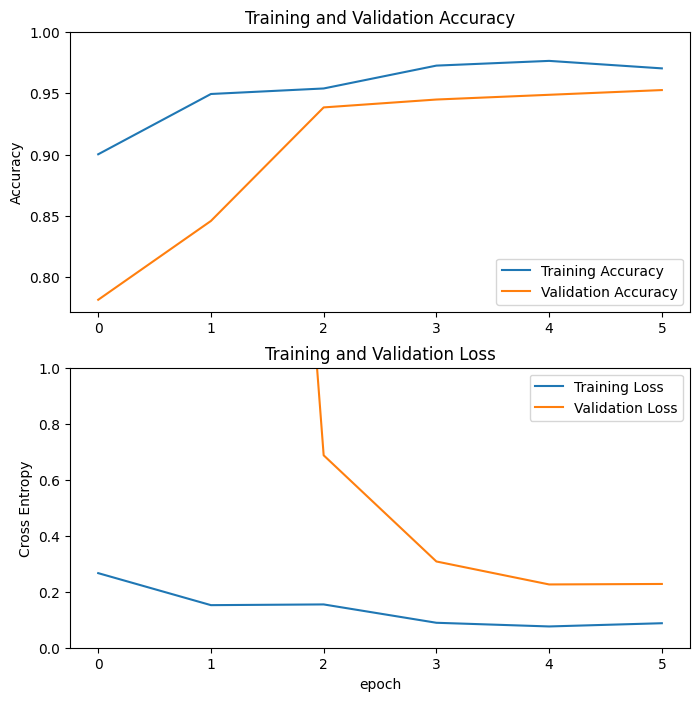

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save the model

In [17]:
final_model.save('smile-detection.keras')